## Read the data

In [1578]:
import pandas as pd

df = pd.read_excel('madrid_rent_data.xlsx')

df_original = df.__deepcopy__()

## Explore the data
df.head()

,Id,District,Address,Number,Area,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,Ciudad Lineal,Piso en Quintana,NaN,Quintana,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,Ciudad Lineal,Piso en calle de Arturo Soria,NaN,Costillares,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,Ciudad Lineal,Piso en calle de Vicente Muzas,4,Colina,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,Ciudad Lineal,Piso en calle Badajoz,NaN,San Pascual,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,Ciudad Lineal,Piso en calle de Nuestra Señora del Villar,9,Ventas,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Remove uneeded columns

In [1579]:
df = df.drop(columns=['Address', 'Number', 'Area', 'District'])

df.head()

,Id,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Get the data types and replace null values

In [1580]:
# Print data types
df.dtypes

Id                int64
Rent              int64
Bedrooms        float64
Sq.Mt             int64
Floor           float64
Outer           float64
Elevator        float64
Penthouse         int64
Cottage           int64
Duplex            int64
Semidetached      int64
dtype: object

In [1581]:
# Check for null values
df.isnull().sum()

Id                0
Rent              0
Bedrooms         89
Sq.Mt             0
Floor           141
Outer           162
Elevator        133
Penthouse         0
Cottage           0
Duplex            0
Semidetached      0
dtype: int64

In [1582]:
# df['Area'] = df['Area'].replace(0, "Unknown")
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].mean())
df['Floor'] = df['Floor'].fillna(0)
df['Outer'] = df['Outer'].fillna(0.5)
df['Elevator'] = df['Elevator'].fillna(0.5)

## Separate labels and features

In [1583]:
labels = df.pop('Id')
x = df

## Feature engineering

In [1584]:
import numpy as np
# Add new features

# # Basic rent per square meter
# x['rent_per_sqm'] = (x['Rent'] / (x['Sq.Mt'] + 1))
# x.drop(columns=['Sq.Mt'], inplace=True)

# # Floor efficiency (higher floors might be more expensive)
# x['floor_efficiency'] = x['Floor'] / (x['Floor'].max() + 1)

# # Size categories
# x['size_category'] = pd.cut(x['Sq.Mt'], bins=[0, 50, 80, 120, 200, float('inf')], 
#                            labels=[1, 2, 3, 4, 5]).astype(float)

# # Rent categories
# x['rent_category'] = pd.cut(x['Rent'], bins=[0, 1000, 1500, 2500, 4000, float('inf')], 
#                           labels=[1, 2, 3, 4, 5]).astype(float)

# # # Luxury features combination
# x['luxury_score'] = (x['Penthouse'] + x['Cottage'] + x['Duplex'] + x['Semidetached'] + 
#                     x['Elevator'] + x['Outer'])

# # Price per bedroom
# x['rent_per_bedroom'] = x['Rent'] / (x['Bedrooms'] + 1)  # +1 to avoid division by zero

# # Area efficiency (rent per bedroom per sqm)
# x['area_efficiency'] = x['rent_per_bedroom'] / (x['Sq.Mt'] + 1)


In [1585]:
x.head()

,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,800,2.0,60,3.0,1.0,0.0,0,0,0,0


In [1586]:
def is_categorical(column):
    return column.dtype == 'object' or column.dtype == 'category'

def is_numerical(column):
    return column.dtype == 'float64' or column.dtype == 'int64'



In [1587]:
# Find the categorical columns and numerical columns that we want to preprocess

categorical_columns = [f for f in x.columns if is_categorical(x[f])]

# We want to keep these numerical columns as they are
whitelist_numerical_columns = ['Outer', 'Elevator', 'Penthouse', 'Cottage', 'Duplex', 'Semidetached']  

numerical_columns = [f for f in x.columns if is_numerical(x[f]) and f not in whitelist_numerical_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: []
Numerical columns: ['Rent', 'Bedrooms', 'Sq.Mt', 'Floor']


In [1588]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create pipeline for categorical variables 
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Create pipeline for numerical variables
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_columns),
        ('numerical', numerical_pipeline, numerical_columns)
    ], 
    remainder="passthrough"
)

In [1589]:
x = preprocessor.fit_transform(x)

# turn into dataframe
x = pd.DataFrame(x)

# rename columns
x.columns = preprocessor.get_feature_names_out()

x.head()

,numerical__Rent,numerical__Bedrooms,numerical__Sq.Mt,numerical__Floor,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
0,-0.422876,-0.378295,-0.491885,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
1,0.714159,1.971365,1.132764,-0.023297,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.422876,-0.378295,-0.249916,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.222223,0.404925,-0.077081,-0.021172,1.0,1.0,0.0,0.0,0.0,0.0
4,-0.757298,-0.378295,-0.595586,-0.022234,1.0,0.0,0.0,0.0,0.0,0.0


## Show correlation betwenn features

In [1590]:
CORR_THRESHOLD = 0.6

def print_corr_matrix(x: pd.DataFrame):
    columns_to_drop = []
    corr_matrix = x.corr()
    corr_pairs = corr_matrix.abs().unstack().reset_index()
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    filtered_corr = corr_pairs[(corr_pairs['Variable 1'] != corr_pairs['Variable 2']) & (corr_pairs['Correlation'] > CORR_THRESHOLD)]
    sorted_corr = filtered_corr.sort_values(by='Correlation', ascending=False).drop_duplicates(subset=['Correlation'])
    sorted_corr.reset_index(drop=True, inplace=True)
    for index, row in sorted_corr.iterrows():
        if row['Variable 1'] in x.columns and row['Variable 2'] in x.columns:
            columns_to_drop.append(row['Variable 1'])
            # columns_to_drop.append(row['Variable 2'])
    columns_to_drop = list(set(columns_to_drop))
    return sorted_corr, columns_to_drop

In [1591]:
corr_df, columns_to_drop = print_corr_matrix(x)

corr_df

,Variable 1,Variable 2,Correlation
0,numerical__Rent,numerical__Sq.Mt,0.826007
1,numerical__Bedrooms,numerical__Sq.Mt,0.740397
2,numerical__Rent,numerical__Bedrooms,0.612110
3,numerical__Sq.Mt,remainder__Cottage,0.605316


In [1592]:
# Remove variables with high correlation
print(f"Removing these columns: {columns_to_drop}")
x = x.drop(columns=columns_to_drop)

Removing these columns: ['numerical__Bedrooms', 'numerical__Sq.Mt', 'numerical__Rent']


In [1593]:
corr_df, _ = print_corr_matrix(x)

corr_df

,Variable 1,Variable 2,Correlation


In [1594]:
x.head()

,numerical__Floor,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
0,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
1,-0.023297,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.021172,1.0,1.0,0.0,0.0,0.0,0.0
4,-0.022234,1.0,0.0,0.0,0.0,0.0,0.0


## Remove outliers

In [1595]:
from sklearn.ensemble import IsolationForest

# Detect outliers using IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(x)

# Keep only non-outliers (outlier_pred == 1)
x = x[outlier_pred == 1].reset_index(drop=True)

# Also filter df_original to keep only non-outlier rows
df_original = df_original[outlier_pred == 1].reset_index(drop=True)

## Do the elbow method to find the best number of clusters

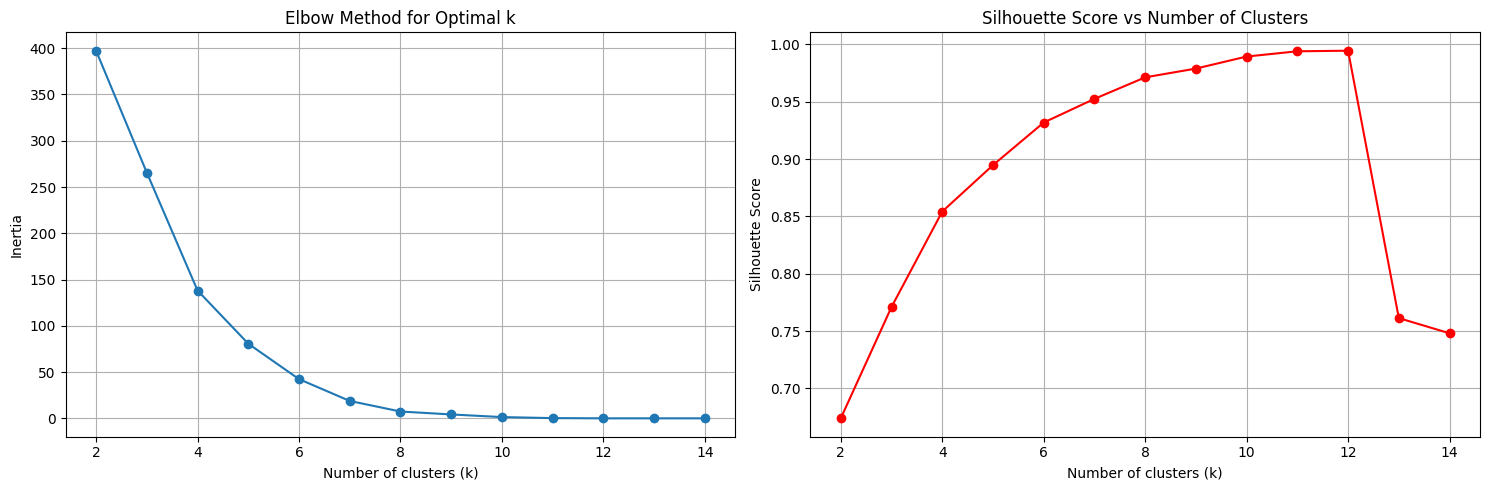

Optimal number of clusters based on silhouette score: 12
Best silhouette score: 0.995


In [1596]:
# Enhanced elbow method with silhouette analysis
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

RANDOM_STATE = 42

# Test different numbers of clusters
MAX_CLUSTERS = 15
K_range = range(2, MAX_CLUSTERS)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(x)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x, kmeans.labels_))

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K_range, inertias, marker='o')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, marker='o', color='red')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

# Update N_CLUSTERS
N_CLUSTERS = 4

## Run K-means clustering

In [1597]:
# Improved K-means clustering with optimized parameters
from sklearn.cluster import KMeans

# Use the optimal number of clusters found in the previous cell
print(f"Using {N_CLUSTERS} clusters for final clustering")

# Enhanced K-means with better parameters
clustering = KMeans(
    n_clusters=N_CLUSTERS, 
    random_state=RANDOM_STATE,
    n_init=20,  # Run multiple initializations
    max_iter=300,  # More iterations for convergence
)

clustering.fit(x)
labels = clustering.predict(x)
centroids = clustering.cluster_centers_

# Cluster labels
df_original['Cluster'] = clustering.labels_+1

df_original[["Id", "Cluster"]].sort_values("Cluster")

Using 4 clusters for final clustering


,Id,Cluster
0,1,1
1210,1343,1
1209,1342,1
1207,1339,1
1206,1337,1
...,...,...
1493,1648,4
641,727,4
1830,2022,4
640,726,4


## Show the cluster sizes

In [1598]:
clustersizes = df_original.groupby('Cluster')['Id'].count().reset_index()
clustersizes.rename(columns={'Id': 'Count'}, inplace=True)

clustersizes

,Cluster,Count
0,1,1335
1,2,314
2,3,146
3,4,191


## Calculate the silhouette score and inertia

In [1599]:
from sklearn.metrics import silhouette_score
import numpy as np

group_column = df_original["Cluster"]
silhouette_avg = silhouette_score(x, group_column)

# Inertia does not exist in hierarchical algoritm in scikit, so we need to calculate it
centroids = np.array([x[group_column == i].mean(axis=0) for i in range(N_CLUSTERS)])
inertia = sum(
    np.sum(np.linalg.norm(x[group_column == i] - centroids[i], axis=1)**2)
    for i in range(N_CLUSTERS)
)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Inertia: {inertia:.3f}")

Silhouette Score: 0.854
Inertia: 134.434


## Calculate the relative importance of the features

In [1600]:
def calculate_importances(df, variables, cluster_col='Cluster'):
    overall_means = df[variables].mean()
    cluster_means = df.groupby(cluster_col)[variables].mean()
    cluster_sizes = df[cluster_col].value_counts()

    # Numerator: variance between clusters
    ss_between = ((cluster_means - overall_means) ** 2).multiply(cluster_sizes, axis=0).sum()

    # Denominator: total variance
    ss_total = ((df[variables] - overall_means) ** 2).sum()

    importance = (ss_between / ss_total).sort_values(ascending=False)
    return importance.to_frame(name='relative importance')


numerical_columns = [f for f in df_original.columns if is_numerical(df_original[f]) and f != 'Id']
importance_df = calculate_importances(df_original, variables=numerical_columns)
print('Numeric variable importances:', "\n")
print(importance_df)

Numeric variable importances: 

              relative importance
Elevator                 1.414508
Penthouse                1.000000
Outer                    0.869854
Cottage                  0.163034
Floor                    0.127602
Sq.Mt                    0.035103
Bedrooms                 0.029233
Rent                     0.026922
Duplex                   0.005965
Semidetached                  NaN


## Describe the clusters

In [1601]:
import pandas as pd

# df_prof will store cluster averages to calculate profile and global metrics
df_prof = df_original.drop(columns="Id", axis=1).select_dtypes(include=['number'])
df_prof = df_prof.groupby("Cluster").mean().transpose()
df_prof["Average"] = df_prof.mean(axis=1)
df_prof["Std.dev"] = df_prof.std(axis=1)
df_prof

Cluster,1,2,3,4,Average,Std.dev
Rent,1937.913109,1829.277070,2498.520548,1324.450262,1897.540247,417.102890
Bedrooms,2.490683,2.697987,2.391608,1.848837,2.357279,0.313676
Sq.Mt,123.931086,156.579618,147.130137,72.769634,125.102619,32.465855
Floor,3.503373,1.794686,5.664384,3.000000,3.490611,1.400206
Outer,1.000000,0.696970,1.000000,0.000000,0.674242,0.408459
Elevator,1.000000,0.000000,1.000000,1.000000,0.750000,0.433013
Penthouse,0.000000,0.000000,1.000000,0.000000,0.250000,0.433013
Cottage,0.000000,0.187898,0.000000,0.000000,0.046975,0.081362
Duplex,0.017978,0.000000,0.000000,0.000000,0.004494,0.007784
Semidetached,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 733.2777777777777, 'Cluster')

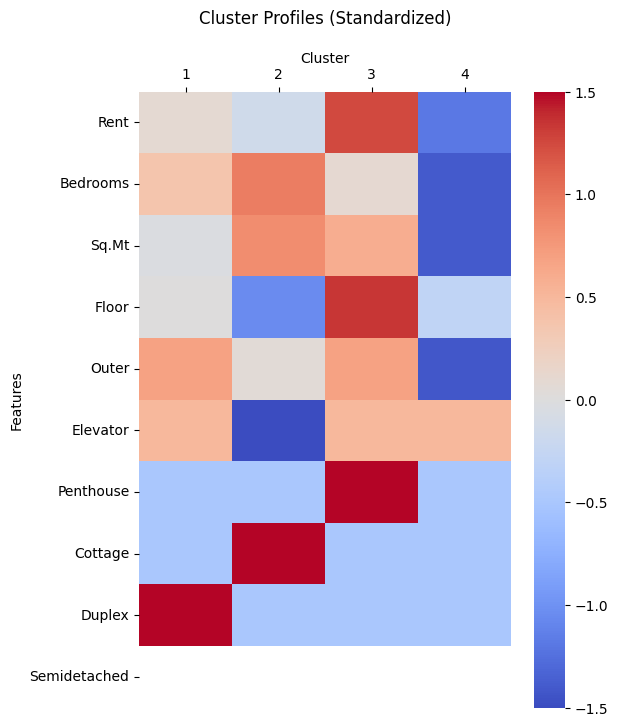

In [1602]:
import seaborn as sns

# Standardize each row (z-score normalization)
# Only use the cluster columns (exclude Average and Std.dev for the heatmap)
df_prof_normalized = df_prof.iloc[:, :-2]  # Get only cluster columns

# Calculate z-scores: (value - row_mean) / row_std
df_prof_normalized = df_prof_normalized.sub(df_prof_normalized.mean(axis=1), axis=0).div(df_prof_normalized.std(axis=1), axis=0)

plt.figure(figsize=(6, 8))  
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
sns.heatmap(df_prof_normalized, cmap="coolwarm", annot=False, cbar=True, center=0)
plt.title('Cluster Profiles (Standardized)', pad=20)
plt.ylabel('Features')
plt.xlabel('Cluster')